AlexNet - image classifier

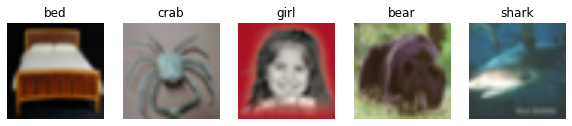

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# CIFAR-100 class names
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Load the CIFAR-100 dataset
cifar100 = tf.keras.datasets.cifar100 
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Define the target image size
target_size = (224, 224)

# Function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, target_size)
    return image, label

# Convert to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Apply the resize function to the datasets
train_ds = train_ds.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Cache the datasets
train_ds = train_ds.cache()
test_ds = test_ds.cache()

# Shuffle, batch, and prefetch the datasets
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=3000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Function to get class names from labels
def get_class_names(labels):
    return [cifar100_classes[label[0]] for label in labels]

# Example usage: Display first 5 resized training images with their class names
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_class_names(labels.numpy())[i])
        plt.axis("off")
    plt.show()

In [16]:

#data augmentation
from tensorflow.keras import Sequential, layers
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [17]:
# TODO - Define AlexNet model.
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

alex_net = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    Conv2D(96, 11, strides=4, activation="relu"),
    MaxPooling2D(3, strides=2),
    Conv2D(256, 5, padding="same", activation="relu"),
    MaxPooling2D(3, 2),
    Conv2D(384, 3, padding="same", activation="relu"),
    Conv2D(384, 3, padding="same", activation="relu"),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(3, strides=2),
    Flatten(),
    Dense(4096, activation="relu"),
    Dropout(0.5),
    Dense(4096, activation="relu"),
    Dropout(0.5),
    Dense(len(cifar100_classes))  # we use the length of labels as the dim of output layer.
])

In [ ]:
# Print the summary
alex_net.summary()
#train
alex_net.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Train the model
history = alex_net.fit(train_ds,
                         batch_size=batch_size,
                         epochs=10,
                         validation_data=test_ds)

# Evaluate the model
test_loss, test_accuracy = alex_net.evaluate(test_ds)
print("Test Accuracy:", test_accuracy)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()